In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
import re

nlp = spacy.load('en_core_web_sm')

try:
    @Language.factory("language_detector")
    def get_lang_detector(nlp, name):
        return LanguageDetector()
    nlp.add_pipe('language_detector', last=True)
except Exception as e:
    pass

In [3]:
train_df = pd.read_csv('../data/train.csv')


In [4]:
def is_eng(title, content):
    if type(title) == float and type(content) == float:
        return False
    elif type(title) == float:
        doc = nlp(content)
        out = doc._.language
        return out['language'] == 'en'
    else:
        doc = nlp(title)
        out = doc._.language
        return out['language'] == 'en'
        
en_train_df = train_df.loc[[is_eng(x[0], x[1]) for x in train_df[['title', 'text']].values]]

In [5]:
print(en_train_df.shape)
en_train_df.head()

(19799, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
en_train_df['label'].value_counts(normalize=True)
# 0 - reliable
# 1 - unreliable

0    0.517198
1    0.482802
Name: label, dtype: float64

# Title Features

In [7]:
en_train_df.sample(10)[['title', 'label']].values

array([['Cop Caught on His Own Body Camera Stealing Money From Unconscious Crash Victim',
        1],
       ['Letter of Recommendation: The Useless Machine - The New York Times',
        0],
       ['Lowry And McIlroy Off To Good Start At BLTC-NTPL-BDTN-STFL Tournament',
        1],
       ['U.S. Athletes Reassured After New Russian Hack - The New York Times',
        0],
       ['Donald Trump’s Victory Was Built on Unique Coalition of White Voters - The New York Times',
        0],
       ['Will the Real Democracy Lovers Please Stand Up? - The New York Times',
        0],
       ['“Florida Man” In The Headline Doesn’t Mean “Redneck”–Could Be A BLM Inspired Crime',
        1],
       ['Kenya’s Collective ‘Uh-Oh’: Another Election Is Coming - The New York Times',
        0],
       ['Court Throws Out $655.5 Million Terrorism Verdict Against Palestinian Groups - The New York Times',
        0],
       ['Susan Rice, Ex-Obama Adviser, Is Back in Political Cross Hairs Over Surveillance - T

In [8]:
sample1 = 'Second Powerful Earthquake Strikes Japan - The New York Times'
sample2 = 'Obamacare is Meant to Fail in Order to Usher in Government-Run Socialist Health Care'
sample3 = 'FLYNN: Obama Would Not Be First President to Spy on Political Enemies - Breitbart'
sample4 = 'BREAKING: It’s Going Down – the Clinton Investigation JUST GOT REAL' # '–' is not dash '-'
sample5 = 'Working class man not particularly angry'
sample6 = 'Has George Soros Committed Treason?'

pattern = r'- [a-zA-Z0-9\s]+$'
print(re.search(pattern=pattern, string=sample3))

def contains_source(title):
    pattern = r'- [a-zA-Z0-9\s]+$'
    if type(title) == float:
        return np.nan
    elif re.search(pattern=pattern, string=title):
        return 1
    else:
        return 0

def num_caps(title):
    if type(title) == float:
        return np.nan
    else:
        tokens = title.split()
        return len([token for token in tokens if token.isupper()])

def title_len(title):
    if type(title) == float:
        return np.nan
    else:
        return len(title.split())

def cap_format(title):
    if type(title) == float:
        return np.nan
    else:
        return np.mean([token[0].isupper() for token in title.split()])

def num_att_punct(title):
    if type(title) == float:
        return np.nan
    else:
        return title.count('?') + title.count('!')


<re.Match object; span=(70, 81), match='- Breitbart'>


In [9]:
en_train_df.loc[~en_train_df['title'].isna()] \
    .assign(contains_source=lambda x: x.title.apply(contains_source))\
    .groupby('label')\
    .agg({'contains_source': ['mean', 'std']})

contains_source          
                 mean       std
label                          
0            0.826953  0.378306
1            0.028669  0.166885

In [10]:
en_train_df.loc[~en_train_df['title'].isna()] \
    .assign(num_caps=lambda x: x.title.apply(num_caps))[['label', 'num_caps']]\
    .groupby('label')\
    .agg({'num_caps': ['mean', 'std']})

num_caps          
           mean       std
label                    
0      0.259277  0.515472
1      0.664490  1.505665

<AxesSubplot:title={'center':'title_len'}, xlabel='[label]'>

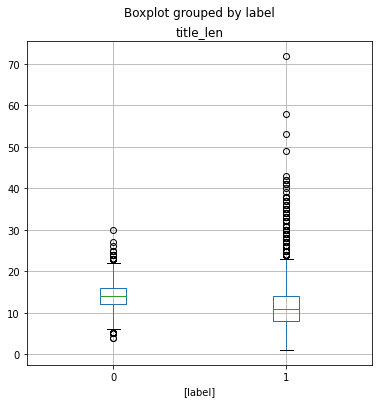

In [11]:
en_train_df.loc[~en_train_df['title'].isna()] \
    .assign(title_len=lambda x: x.title.apply(lambda y: len(y.split())))[['label', 'title_len']]\
    .boxplot(by='label', figsize=(6,6))

<AxesSubplot:title={'center':'cap_format'}, xlabel='[label]'>

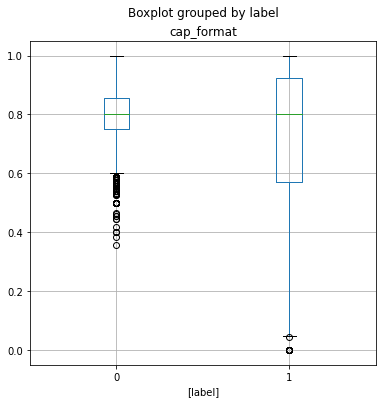

In [12]:
en_train_df.loc[~en_train_df['title'].isna()] \
    .assign(cap_format=lambda x: x.title.apply(cap_format))[['label', 'cap_format']]\
    .boxplot(by='label', figsize=(6,6))

In [13]:
en_train_df.loc[~en_train_df['title'].isna()] \
    .assign(num_att_punct=lambda x: x.title.apply(num_att_punct))[['label', 'num_att_punct']]\
    .groupby('label')\
    .agg({'num_att_punct': ['mean', 'std']})

num_att_punct          
               mean       std
label                        
0          0.048145  0.223020
1          0.145783  0.428556

# Content Features

In [33]:
def preprocess(text):
    if type(text) == float:
        return text
    out = re.sub(r'\n', r'\. ', text)
    out = re.sub(r'\.+', r'\.', out)
    out = re.sub(r'\s+', ' ', out)
    out = re.sub(r'[”“]', '"', out)
    out = re.sub(r'—', '-', out)
    return out.strip()

In [34]:
en_train_df['processed_text'] = en_train_df['text'].apply(preprocess)

/tmp/ipykernel_15944/247850255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_train_df['processed_text'] = en_train_df['text'].apply(preprocess)


In [36]:
en_train_df.sample(1)[['processed_text', 'label']].values

array([['Roger Ailes has died at 77\\. This assesment of his career by our chief television critic was originally published in July 2016, following the departure of Mr\\. Ailes from Fox News\\. American democracy is meant to be \\. Presidents win two terms, maximum\\. Supreme Court justices are one voice among nine (or, currently, eight) senators one in a hundred\\. To amass the kind of power that allows you to shape politics and culture geologically, like a river carving out a canyon, you have to go elsewhere\\. Roger Ailes found that place\\. At Fox News - the outlet Mr\\. Ailes created, ran and drove like a bullet train for two decades - he was a unitary force\\. And he was not until Thursday, when he stepped down over charges, which began with a lawsuit by the former Fox anchor Gretchen Carlson, that he sexually harassed a series of women over the years\\. With Fox News, Mr\\. Ailes introduced a brash, style that influences much of today’s media\\. But the closest comparison for hi